  <h1 style="color: brown;">1. Introduction</h1>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p>In neural networks, the number of nodes in the hidden layer is a key factor that affects the model's capacity to learn and generalize. This task investigates whether increasing the number of nodes in the hidden layer improves the accuracy of the worst-performing case from the first experiment, which occurred at a noise standard deviation of 0.5, resulting in a test accuracy of 72%. The experiment explores different numbers of hidden nodes, specifically using variations of 8, 16, 32, 64, 128, and 256 nodes, to determine whether this change can improve the model's ability to handle noisy data.</p>

  <p>To support this investigation, the model is trained for 100 epochs, just like in the first experiment, and the results are compared. Any improvements or lack thereof are discussed, along with plausible reasons for the outcomes. The MLP model architecture remains consistent with previous experiments, consisting of a single hidden layer and using the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.1. The loss function used is binary cross-entropy with logits (BCEWithLogitsLoss), and the Tanh activation function is applied to the hidden layer. The training dataset consists of 2,500 samples, and the test dataset includes 500 samples.</p>

</div>

  <h1 style="color: brown;">2. Importing Libraries</h1> 

In [1]:
from tqdm import tqdm  
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(88)

  <h1 style="color: brown;">3. XOR Dataset Class Implementation</h1> 

In [2]:
class XOR_Dataset(torch.utils.data.Dataset):
    # Defining the constructor of the XOR_Dataset class, which initializes the dataset with a specified size and standard deviation (std).
    def __init__(self, size, std=0.5):  # Default std is set to 0.5
        # Calling the parent class constructor (from torch.utils.data.Dataset)
        super().__init__()
        # Storing the dataset size and the noise level (std) as class attributes
        self.size = size
        self.std = std
        # Generating the XOR dataset with continuous noise
        self.generate_cont_xor()

    # Defining a method to generate the XOR data with added noise
    def generate_cont_xor(self):
        # Generating random binary pairs (0 or 1) for the dataset, with shape (size, 2)
        self.data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        # Creating XOR labels based on the sum of the binary pairs (XOR logic: sum == 1 is true)
        self.label = (self.data.sum(dim=1) == 1).to(torch.float32).unsqueeze(1)
        # Adding Gaussian noise to the data points, scaled by the standard deviation (std)
        self.data += self.std * torch.randn(self.data.shape)

    # Defining a method to return the size of the dataset
    def __len__(self):
        # Returning the total number of samples in the dataset
        return self.size

    # Defining a method to retrieve a data sample and its corresponding label by index
    def __getitem__(self, idx):
        # Returning the data sample at the given index (idx) and its associated label
        return self.data[idx], self.label[idx]

  <h1 style="color: brown;">4. XOR Classifier Model Implementation</h1>

In [3]:
class XOR_Classifier(nn.Module):
    # Defining the constructor of the XOR_Classifier class to initialize the network architecture
    def __init__(self, num_inputs, num_hidden, num_outputs):
        # Calling the parent class constructor (from nn.Module)
        super().__init__()
        # Defining the first fully connected layer (linear layer) that maps from the input features to the hidden units
        self.linear1 = nn.Linear(num_inputs, num_hidden)  # The number of hidden units is passed dynamically
        # Defining the activation function as Tanh, introducing non-linearity between layers
        self.activation = nn.Tanh()
        # Defining the second fully connected layer (linear layer) that maps from hidden units to the output
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
    # Defining the forward pass that specifies how data moves through the network
    def forward(self, x):
        # Passing the input 'x' through the first linear layer
        x = self.linear1(x)
        # Applying the Tanh activation function on the output of the first layer
        x = self.activation(x)
        # Passing the result through the second linear layer to produce the final output
        return self.linear2(x)

  <h1 style="color: brown;">5. XOR Classifier Training and Testing</h1> 

In [4]:
# Defining the function to train the model with different numbers of hidden nodes
def train_model_with_varied_hidden_nodes(hidden_node_list, epochs=100):
    # Initializing lists to store training and test accuracies for each hidden node configuration
    train_accuracies = []
    test_accuracies = []
    
    # Looping through the list of different hidden node values
    for hidden_nodes in hidden_node_list:
        # Creating training and testing datasets with the default standard deviation (std=0.5)
        train_dataset = XOR_Dataset(size=2500)
        test_dataset = XOR_Dataset(size=500)
        # Creating data loaders to load the dataset in batches
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

        # Initializing the XOR classifier model with dynamic hidden nodes
        model = XOR_Classifier(num_inputs=2, num_hidden=hidden_nodes, num_outputs=1)
        # Defining the loss function (binary cross entropy with logits)
        loss_module = nn.BCEWithLogitsLoss()
        # Defining the optimizer as stochastic gradient descent (SGD) with a learning rate of 0.1
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

        # Entering the training loop for the specified number of epochs
        model.train()  # Setting the model to training mode
        for epoch in tqdm(range(epochs), desc=f'Training with {hidden_nodes} hidden nodes', leave=True):
            # Looping through the training data in batches
            for data, label in train_loader:
                optimizer.zero_grad()  # Clearing the gradients from the previous step
                output = model(data)  # Performing the forward pass through the model
                loss = loss_module(output, label)  # Computing the loss
                loss.backward()  # Performing backpropagation to calculate gradients
                optimizer.step()  # Updating the model's weights

        # After training, computing training and testing accuracies
        train_acc = compute_accuracy(train_loader, model)  # Calculating training accuracy
        test_acc = compute_accuracy(test_loader, model)  # Calculating testing accuracy
        
        # Storing the accuracy results for each hidden node configuration
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Printing the results for the current hidden node configuration
        print(f'Hidden Nodes: {hidden_nodes}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

    # Returning the lists of training and test accuracies
    return train_accuracies, test_accuracies

# Defining the function to compute accuracy of the model
def compute_accuracy(loader, model):
    correct = 0  # Initializing counter for correct predictions
    total = 0  # Initializing counter for total number of predictions
    model.eval()  # Setting the model to evaluation mode (disables gradient computation)
    with torch.no_grad():  # Disabling gradient computation for the evaluation process
        # Looping through the data in the data loader
        for data, label in loader:
            output = model(data)  # Performing a forward pass through the model
            predicted = (torch.sigmoid(output) > 0.5).float()  # Applying sigmoid and thresholding to get binary predictions
            total += label.size(0)  # Adding the batch size to the total number of samples
            correct += (predicted == label).sum().item()  # Counting the number of correct predictions
    # Returning the accuracy as a percentage
    return 100 * correct / total

In [5]:
# List of hidden nodes to experiment with
hidden_node_variations = [8, 16, 32, 64, 128, 256]

# Running the experiment by training the model with each hidden node configuration
# and storing the resulting training and test accuracies
train_accuracies, test_accuracies = train_model_with_varied_hidden_nodes(hidden_node_variations)

Training with 8 hidden nodes: 100%|██████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.87it/s]


Hidden Nodes: 8, Training Accuracy: 71.92%, Test Accuracy: 75.40%


Training with 16 hidden nodes: 100%|█████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.36it/s]


Hidden Nodes: 16, Training Accuracy: 73.12%, Test Accuracy: 73.80%


Training with 32 hidden nodes: 100%|█████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.13it/s]


Hidden Nodes: 32, Training Accuracy: 72.76%, Test Accuracy: 71.40%


Training with 64 hidden nodes: 100%|█████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.81it/s]


Hidden Nodes: 64, Training Accuracy: 73.12%, Test Accuracy: 71.60%


Training with 128 hidden nodes: 100%|████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.07it/s]


Hidden Nodes: 128, Training Accuracy: 73.56%, Test Accuracy: 75.40%


Training with 256 hidden nodes: 100%|████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.46it/s]

Hidden Nodes: 256, Training Accuracy: 72.56%, Test Accuracy: 72.80%


  <h1 style="color: brown;">6. Visualization</h1> 

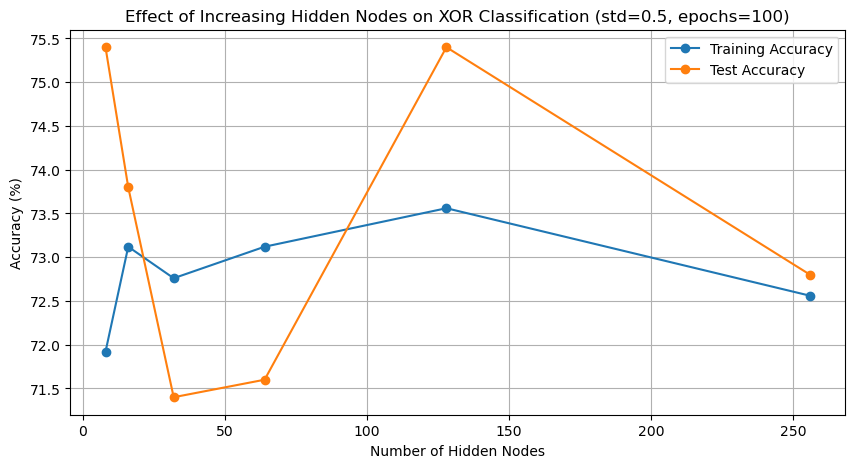

In [6]:
# Plotting the results for the effect of varying hidden nodes on model accuracy
plt.figure(figsize=(10, 5))  # Creating a figure with specified size for better visibility

# Plotting training accuracy against the number of hidden nodes
plt.plot(hidden_node_variations, train_accuracies, label='Training Accuracy', marker='o')

# Plotting test accuracy against the number of hidden nodes
plt.plot(hidden_node_variations, test_accuracies, label='Test Accuracy', marker='o')

# Adding a title to the plot, indicating the purpose of the experiment
plt.title('Effect of Increasing Hidden Nodes on XOR Classification (std=0.5, epochs=100)')

# Labeling the x-axis to indicate the number of hidden nodes
plt.xlabel('Number of Hidden Nodes')

# Labeling the y-axis to indicate the accuracy percentage
plt.ylabel('Accuracy (%)')

# Adding a legend to differentiate between training and test accuracies
plt.legend()

# Adding grid lines to make the plot more readable
plt.grid(True)

# Displaying the plot
plt.show()

  <h1 style="color: brown;">7. Results</h1> 

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">
  
  <p style="font-size: 16px; color: #333;">The following table summarizes the accuracy results for different configurations of hidden nodes:</p>

  <table style="width:100%; border-collapse: collapse; margin: 10px 0; font-size: 16px; color: #333;">
    <tr style="background-color: #8b4513; color: white;">
      <th style="padding: 8px; border: 2px solid black;">Hidden Nodes</th>
      <th style="padding: 8px; border: 2px solid black;">Training Accuracy (%)</th>
      <th style="padding: 8px; border: 2px solid black;">Test Accuracy (%)</th>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">8</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">71.92</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">75.40</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">16</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">73.12</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">73.80</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">32</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">72.76</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">71.40</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">64</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">73.12</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">71.60</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">128</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">73.56</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">75.40</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">256</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">72.56</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">72.80</td>
    </tr>
  </table>

</div>


<h2 style="color: brown;">7.1 Interpretation of Results</h2>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">
  
  <p><strong>Performance with 8 Hidden Nodes:</strong></p>
  <p>Increasing the number of hidden nodes from 4 to 8 results in a test accuracy of 75.40%, which is an improvement over the 72% test accuracy observed with 4 hidden nodes in the first experiment. This suggests that increasing the number of hidden nodes improves the model's ability to generalize to the test data in this particular noisy XOR setting. The training accuracy remains balanced at 71.92%, indicating that the model is learning well without overfitting.</p>

  <p><strong>Performance with 16 Hidden Nodes:</strong></p>
  <p>With 16 hidden nodes, the model achieves a test accuracy of 73.80%, which is slightly lower than with 8 hidden nodes but still above the baseline accuracy of 72%. The training accuracy also improves to 73.12%, showing that the model is learning slightly better as the hidden layer size increases. The drop in test accuracy compared to 8 hidden nodes could suggest that the model is beginning to overfit to the training data, as indicated by the increased training accuracy.</p>

  <p><strong>Decreasing Accuracy with 32 and 64 Hidden Nodes:</strong></p>
  <p>With 32 hidden nodes, the test accuracy drops to 71.40%, which is below the baseline of 72%. This suggests that increasing the number of hidden nodes beyond a certain point does not necessarily improve performance. The training accuracy stabilizes at 72.76%, indicating that the model may be starting to fit the noise in the training data rather than improving generalization. Similarly, with 64 hidden nodes, the test accuracy remains low at 71.60%, while the training accuracy remains relatively unchanged at 73.12%. This shows diminishing returns in both training and test accuracy as the number of hidden nodes increases.</p>

  <p><strong>Improvement at 128 Hidden Nodes:</strong></p>
  <p>At 128 hidden nodes, the model achieves a test accuracy of 75.40%, matching the best result obtained with 8 hidden nodes. The training accuracy slightly improves to 73.56%, suggesting that the model is benefiting from the additional capacity without overfitting. This configuration appears to balance learning capacity and generalization well in this noisy dataset.</p>

  <p><strong>Slight Decrease at 256 Hidden Nodes:</strong></p>
  <p>With 256 hidden nodes, the test accuracy decreases to 72.80%, while the training accuracy drops slightly to 72.56%. This suggests that adding too many nodes may cause the model to overfit to the noisy training data, leading to decreased performance on the test data.</p>

</div>


<h2 style="color: brown;">7.2 Plausible Reasons for Changes in Accuracy</h2> 

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p><strong>Model Capacity and Complexity:</strong></p>
  <p>Increasing the number of hidden nodes from 8 to 128 initially helps the model by providing it with more capacity to capture the complex patterns in the noisy XOR dataset. However, as the number of nodes increases further (to 32, 64, and 256), the model starts overfitting to the noisy training data, resulting in lower test accuracy.</p>

  <p><strong>Effect of Noise on Learning:</strong></p>
  <p>The noisy XOR dataset presents a challenge for the model, as the noise blurs the decision boundaries between classes. Adding more hidden nodes initially helps the model manage this complexity, but beyond a certain point, the model begins to overfit to the noise rather than generalize well.</p>

  <p><strong>Generalization vs. Overfitting:</strong></p>
  <p>The results indicate that there is an optimal range of hidden nodes (around 8 to 128 nodes) where the model is complex enough to handle the noisy data but not so complex that it starts overfitting. The test accuracy reaches its peak at 75.40% with 8 and 128 hidden nodes, suggesting that these configurations strike the best balance between model capacity and generalization. Adding too many nodes (such as 32, 64, and 256) does not provide further benefits and may even harm performance by leading to overfitting.</p

</div>


<h2 style="color: brown;">8. Conclusion</h1>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">
  <p>In conclusion, increasing the number of hidden nodes in the XOR classifier initially improves both training and test accuracy, particularly noticeable between 8 and 128 nodes. The model performs optimally with 8 and 128 hidden nodes, achieving a test accuracy of 75.40%, which marks a significant improvement over the baseline accuracy of 72% observed with 4 hidden nodes.</p>
  <p>However, further increasing the number of nodes beyond 128 leads to diminishing returns and even reduced accuracy due to overfitting. These results suggest that there is an optimal range of hidden nodes for balancing model complexity and generalization. Simply increasing the number of nodes beyond this range does not guarantee better performance, highlighting the importance of strategic layer and neuron configuration in neural network design.</p>

</div>
